In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USDT&limit=1200')
# res = requests.get(endpoint + '?fsym=BTC&tsym=USDT')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

hist = hist[0:-20]
hist.shape

(1181, 8)

In [ ]:

hist = hist[["high","low","open","volumefrom","volumeto","close"]]
hist

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2017-08-13,4267.46,3906.60,3871.50,807.25,3.292236e+06,4078.33
2017-08-14,4480.13,4239.20,4078.33,888.18,3.783654e+06,4260.01
2017-08-15,4347.69,3928.81,4260.01,945.51,3.900897e+06,4125.71
2017-08-16,4396.62,4081.68,4125.71,682.27,2.980014e+06,4367.79
2017-08-17,4473.83,4212.32,4367.79,837.26,3.698963e+06,4417.94
...,...,...,...,...,...,...
2020-11-01,13875.68,13604.73,13779.68,136817.39,1.878636e+09,13740.64
2020-11-02,13810.59,13192.52,13740.64,178659.61,2.417876e+09,13548.77
2020-11-03,14051.42,13285.93,13548.77,99169.42,1.349849e+09,14008.25


In [ ]:
#move close price one step ahead 。 no use. 别人做了.
# price = hist.iat[-1,-1]
# print(price)
# hist['close'] = hist['close'].shift(-1)
# hist.iloc[-1,-1] = price
# hist

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USDT]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

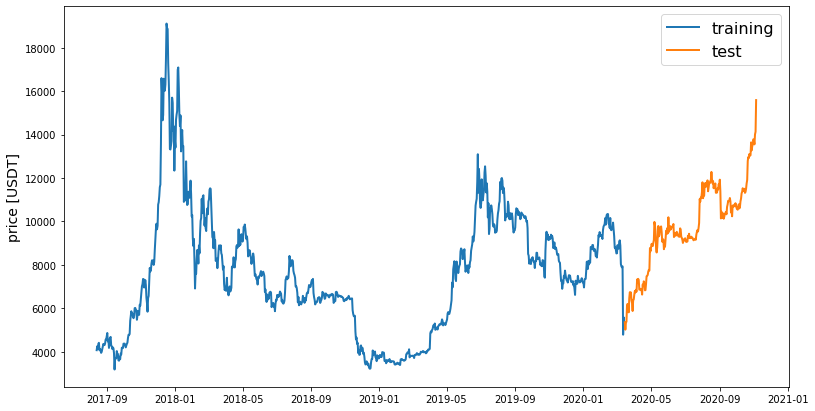

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
def normalise_zero_base(df):
    # print(type(df.iloc[0]), df.iloc[0])
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        # print(tmp., tmp.shape)
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
        # print(len(tmp.values))
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    print("train_data", train_data.shape[0])
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        # print(type(y_train), type(train_data[target_col][:-window_len].values))
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(42)
window_len = 4
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
print(X_train.shape[0], y_train.shape[0])

train_data 945
941 941


In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
# print(X_train)
# X_train = np.asarray(X_train).astype(np.float32)
# y_train = np.asarray(y_train).astype(np.float32)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
30/30 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 3/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 6/20
30/30 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 7/20
30/30 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 8/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 9/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 10/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 11/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 12/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 13/20
30/30 [==============================

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.023238932691790896

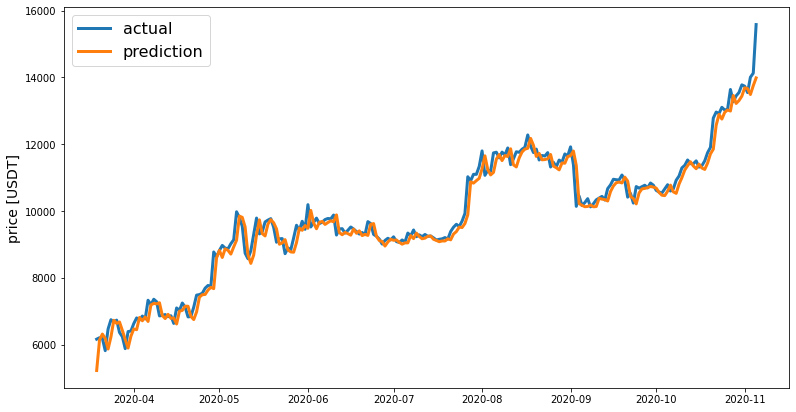

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
#这里不对, 预测出来的数据是第二天值，不是当天的值。应该往前移动一个格子.
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)


In [ ]:
preds

time
2020-03-19     5227.023429
2020-03-20     6141.546077
2020-03-21     6318.414809
2020-03-22     6187.811087
2020-03-23     5869.991788
                  ...     
2020-11-01    13690.781120
2020-11-02    13668.046386
2020-11-03    13491.106619
2020-11-04    13755.775105
2020-11-05    13987.345891
Length: 232, dtype: float64

总天数 232
预测上升正确的天数 29 上升正确比率 0.21804511278195488
预测下降正确的天数 88 下降正确比率 0.8979591836734694
预测正确总比率 0.5043103448275862


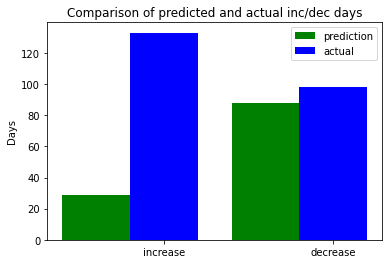

In [ ]:
inc = 0
dec = 0
total_inc, total_dec = 0, 0
for i in range(len(preds)-1):
  if targets[i] < targets[i+1]:
    total_inc += 1
    if targets[i] < preds[i+1]:
      inc += 1
  elif targets[i] > targets[i+1]:
    total_dec += 1
    if targets[i] > preds[i+1]:
      dec += 1
rate = (inc + dec) / len(preds)
print("总天数", len(preds))
print("预测上升正确的天数",inc, "上升正确比率", inc/total_inc)
print("预测下降正确的天数",dec, "下降正确比率", dec/total_dec)
print("预测正确总比率", rate)

def Compare(pred, actual, title):
  name_list = ['increase','decrease']
  num_list = pred
  num_list1 = actual
  x =list(range(len(num_list)))
  total_width, n = 0.8, 2
  width = total_width / n
  
  plt.bar(x, num_list, width=width, label='prediction',fc = 'g')
  for i in range(len(x)):
      x[i] = x[i] + width
  plt.bar(x, num_list1, width=width, label='actual',tick_label = name_list,fc = 'b')
  plt.legend()
  plt.title(title)
  plt.ylabel("Days")
  plt.show()
Compare([inc, dec],[total_inc, total_dec], "Comparison of predicted and actual inc/dec days")

In [ ]:
#做多-计算利润,限定每天买入金额。
money = 0
buy_per_day = 100
bought_volume = 0
fee = 0
for i in range(len(preds)-1):
  
  if targets[i] < preds[i+1]:
    if bought_volume > 0:
      #预测上涨且有股票，继续持有
      pass
    else:
      bought_volume = buy_per_day / targets[i]
      money -= buy_per_day
      fee += buy_per_day * 0.002
      
  else:
    if bought_volume > 0:
      money += targets[i] * bought_volume
      bought_volume = 0
      fee += targets[i] * bought_volume * 0.002
    else:
      #预测下跌且无股票，则不操作。
      pass

money = money + bought_volume * targets[-1]
print("days", len(preds))
print("benifits", money)
print("benifits rate", money/buy_per_day)
print("benifits rate/year", money/buy_per_day * 365 / len(preds))
print("fee", fee)
print("pure benifits rate/year", (money-fee)/buy_per_day * 365 / len(preds))

name_list = ['0.01','0.1',"1","10","100"]
num_list = Eval_linear
plt.bar(range(len(num_list)), num_list,color='r', tick_label=name_list)
plt.ylabel("Eval")
plt.xlabel("C")
plt.title("Linear Kernel")
plt.show()

days 232
benifits 38.11957327690544
benifits rate 0.38119573276905444
benifits rate/year 0.5997260450892451
fee 7.200000000000004
pure benifits rate/year 0.4864501830202795


NameError: ignored

In [ ]:
#做空-计算利润,限定每天买入金额。
money = 0
borrow_per_day = 100
borrow_volume = 0
fee = 0
for i in range(len(preds)-1):
  
  if targets[i] < preds[i+1]:
    if borrow_volume > 0:
      #预测上涨且有借BTC，则还BTC
      money -= borrow_volume * targets[i]
      fee = borrow_volume * targets[i] * 0.002
      borrow_volume = 0
    else:
      #预测上涨且没有借BTC，则无操作
      pass
  else:
    if borrow_volume > 0:
      #预测下降且有借BTC，无操作
      pass
    else:
      #预测下跌且没有借BTC，则借BTC
      borrow_volume = borrow_per_day / targets[i]
      money += borrow_per_day
      fee = borrow_per_day * 0.02
      pass

money = money - borrow_volume * targets[-1]
print("days", len(preds))
print("benifits", money)
print("benifits rate", money/buy_per_day)
print("benifits rate/year", money/buy_per_day * 365 / len(preds))
print("fee", fee)
print("pure benifits rate/year", (money-fee)/buy_per_day * 365 / len(preds))

In [ ]:
#预测后面一天的值
import time
import datetime

X = hist[-window_len:]
if zero_base:
  X = normalise_zero_base(X)
X = [X.values]
X = np.array(X)
pred = model.predict(X).squeeze()
pred = hist[target_col][-window_len] * (pred+1)

today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
print(tomorrow, pred)


In [ ]:
#!!! 有问题,用前面5个x预测后面一个y值。应该会少一个值。

#11.19->17989.083192
#11-20->18104.412399
#2020-11-22->18692.975356
#2020-11-23->18728.463033

In [ ]:
#用过去的数据预测后一天的偏差。 这个没有意义。
# N = X_train.shape[0]
# for i in range(N-1,N):
#   history = model.fit(
#       X_train[0:i], y_train[0:i], epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)
#   targets = train[target_col][window_len+i:i+window_len+1]
#   preds = model.predict(X_train[i:i+1]).squeeze()
  
#   preds = train[target_col].values[i-window_len:i-window_len+1] * (preds + 1)
#   # print(len(targets), len(preds))
#   preds = pd.Series(index=targets.index, data=preds)
#   # line_plot(targets, preds, 'actual', 'prediction', lw=3)
#   print(i, preds, targets.squeeze())